In [1]:
import {display} from 'tslab';
import Jimp from "jimp"
import cv from "@techstark/opencv-js";
import { createWorker } from "tesseract.js";

In [2]:
// notebok util functions
function toImage(imageMat: cv.Mat): Jimp {
  return new Jimp({
    width: imageMat.cols,
    height: imageMat.rows,
    data: Buffer.from(imageMat.data)
  })
}
async function print(imageMat: cv.Mat) {
  const invoke = async () => {
    const outputImage = toImage(imageMat)
    display.png((await outputImage.getBufferAsync(outputImage.getMIME())))
  }
  if (imageMat.type() === cv.CV_8UC1){
    cv.cvtColor(imageMat, imageMat, cv.COLOR_GRAY2RGBA, 0)
    await invoke()
    cv.cvtColor(imageMat, imageMat, cv.COLOR_RGBA2GRAY, 0);
    return
  }
  await invoke()
}

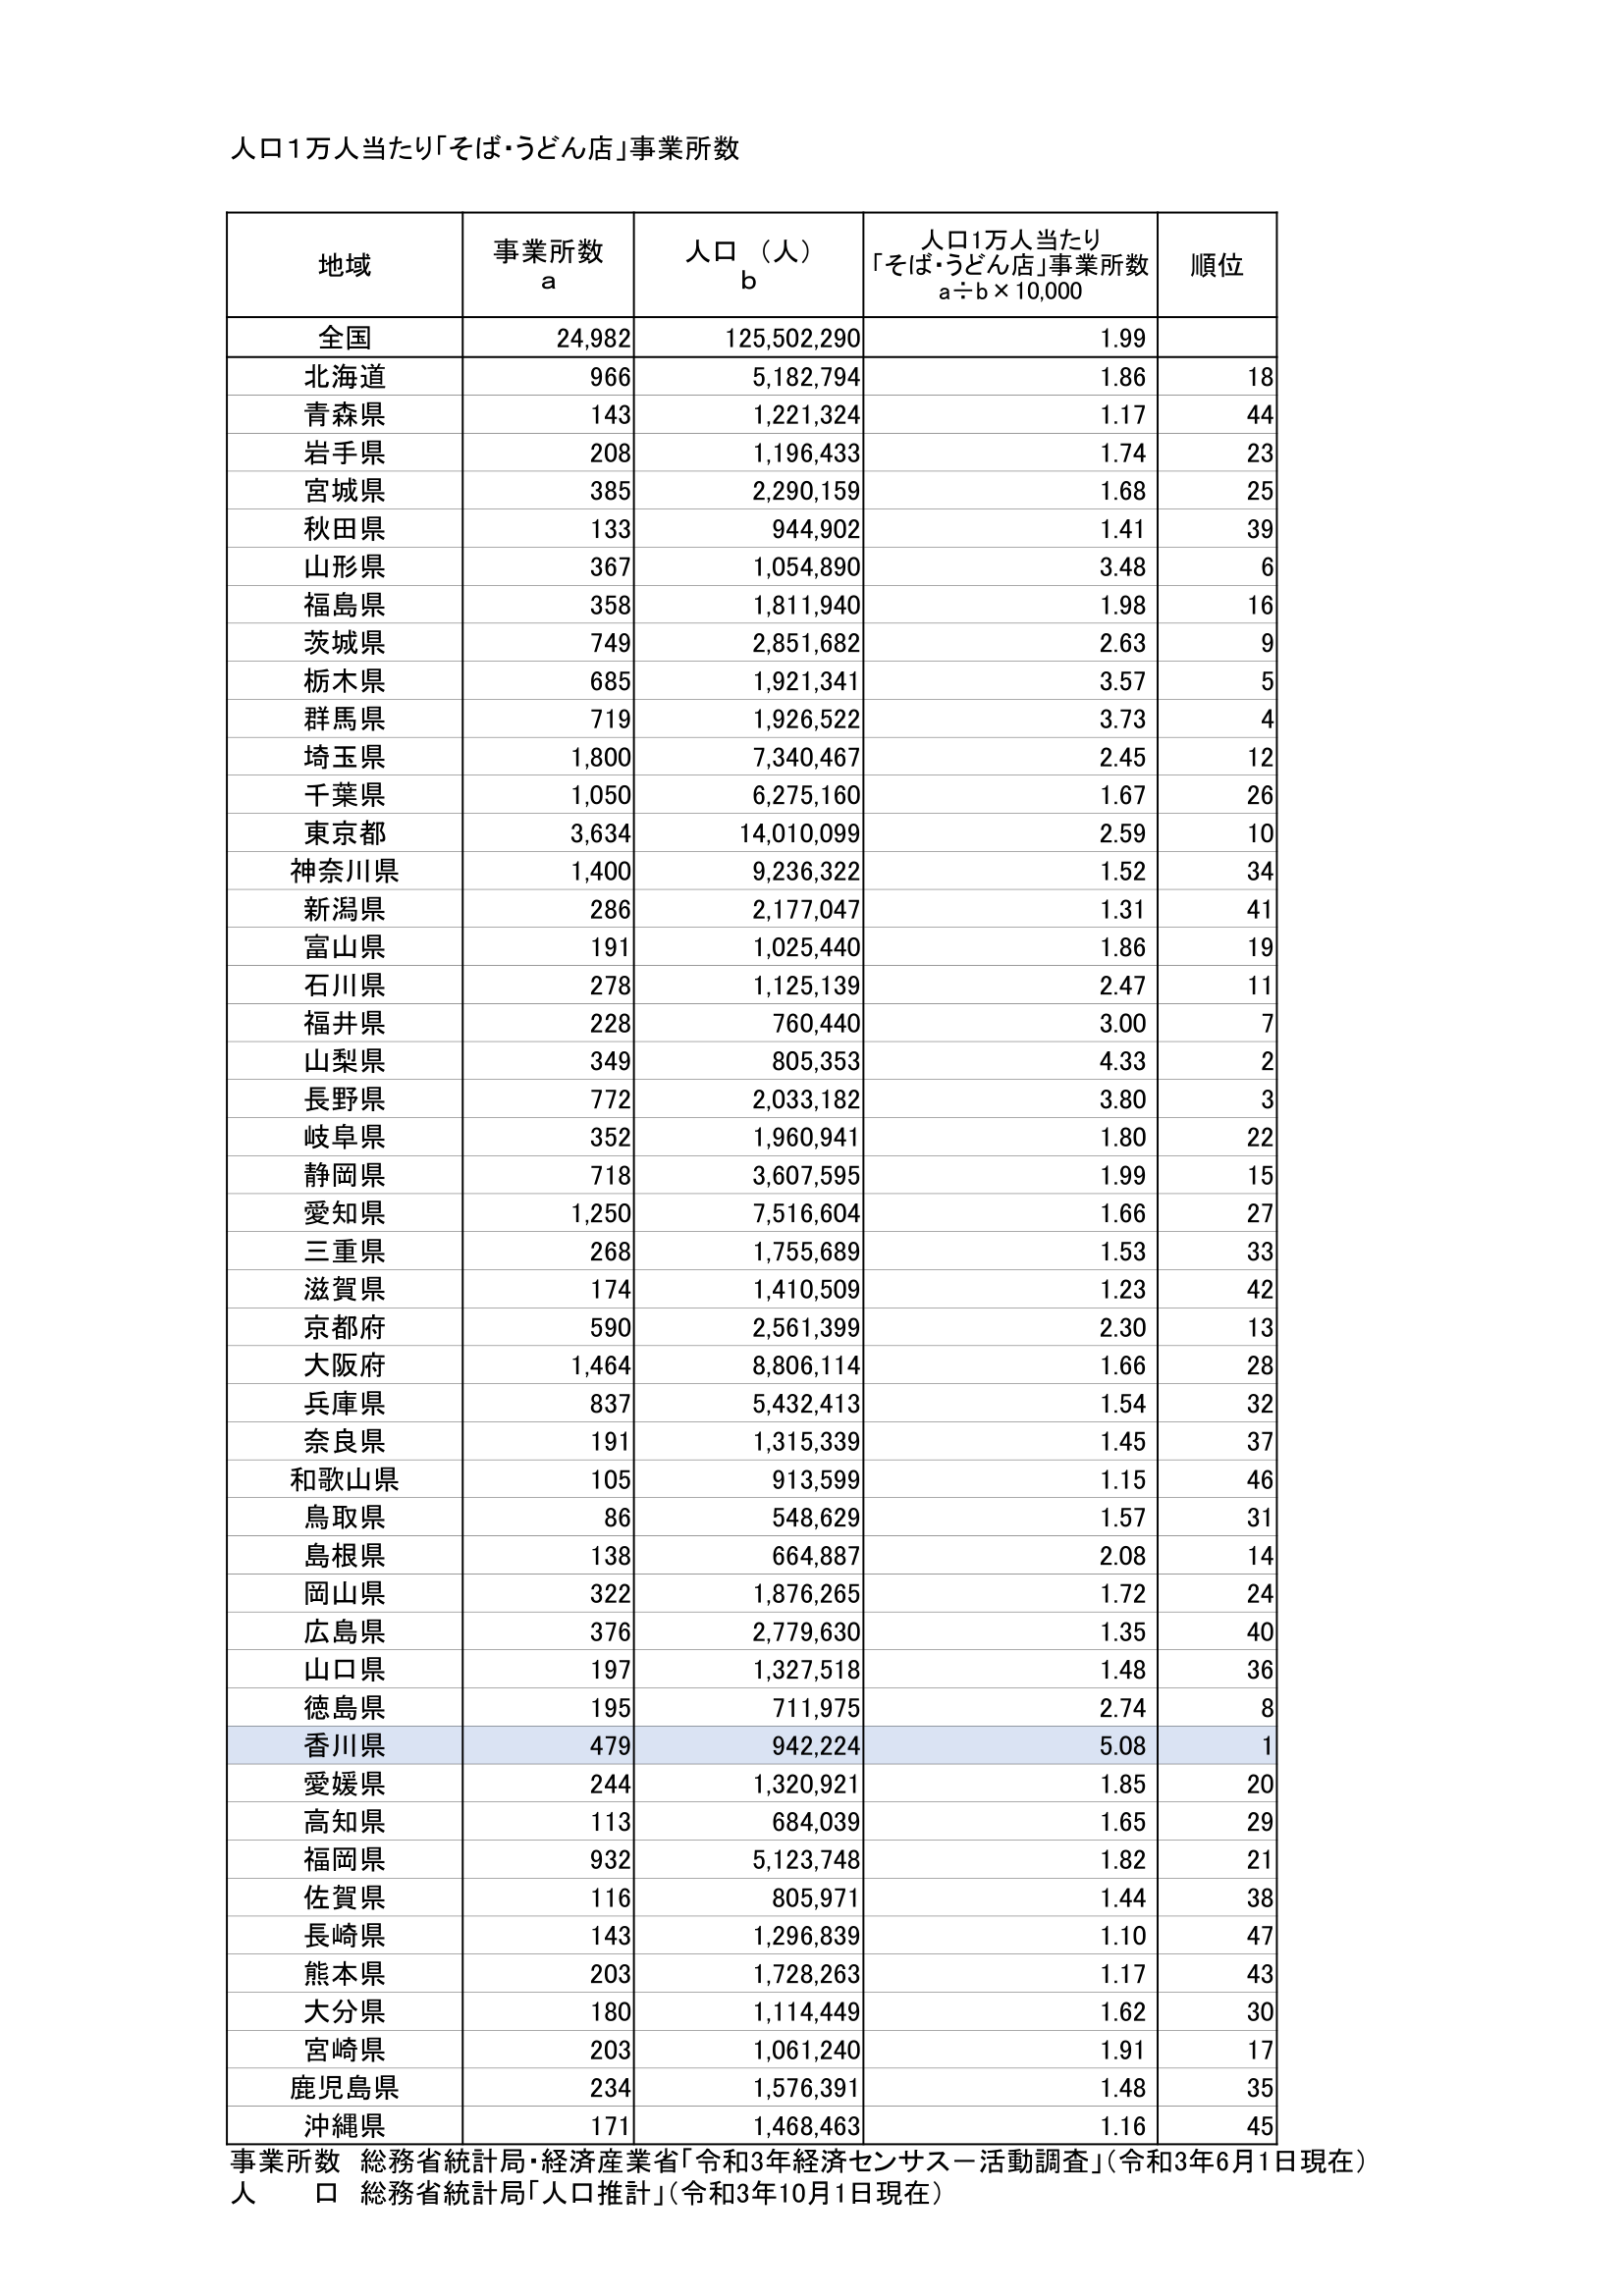

In [3]:
const image = await Jimp.read("../images/udonjouhou_data1-1.png");
const imageMat = cv.matFromImageData(image.bitmap);
await print(imageMat)

In [4]:
// Create a working Mat
const workImage = imageMat.clone()

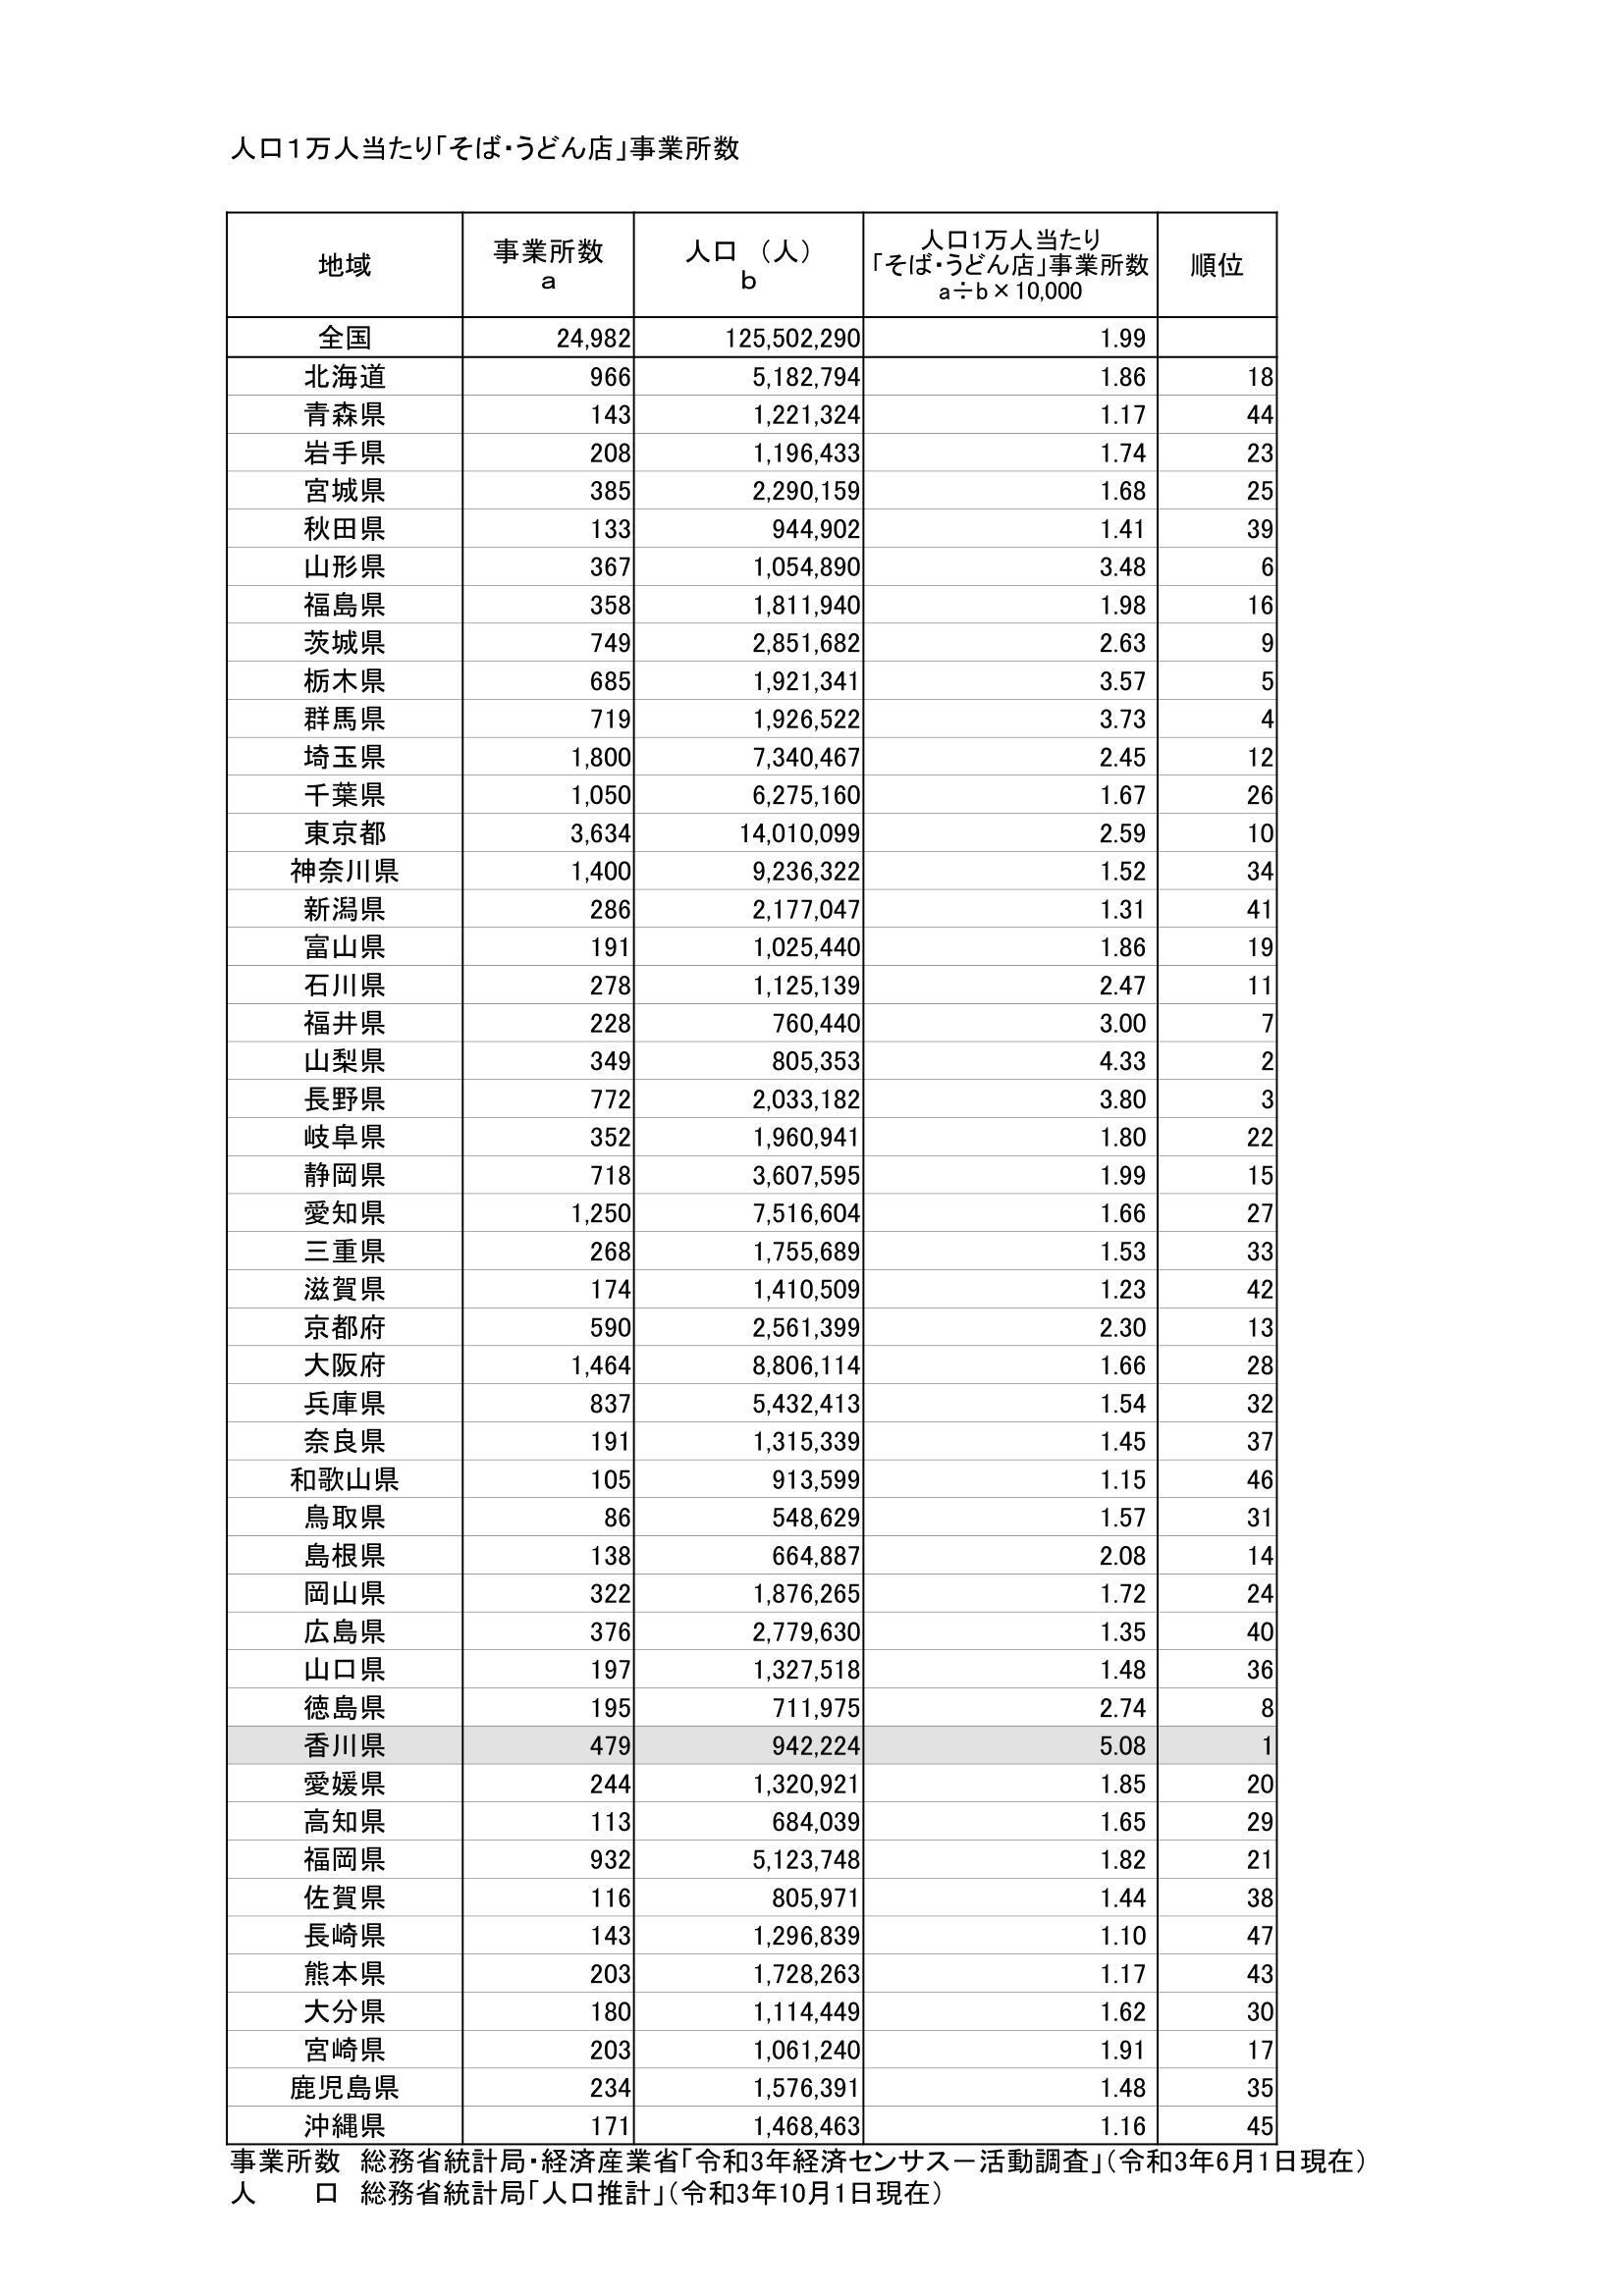

In [5]:
// grayscale
cv.cvtColor(workImage, workImage, cv.COLOR_RGBA2GRAY, 0);
await print(workImage)

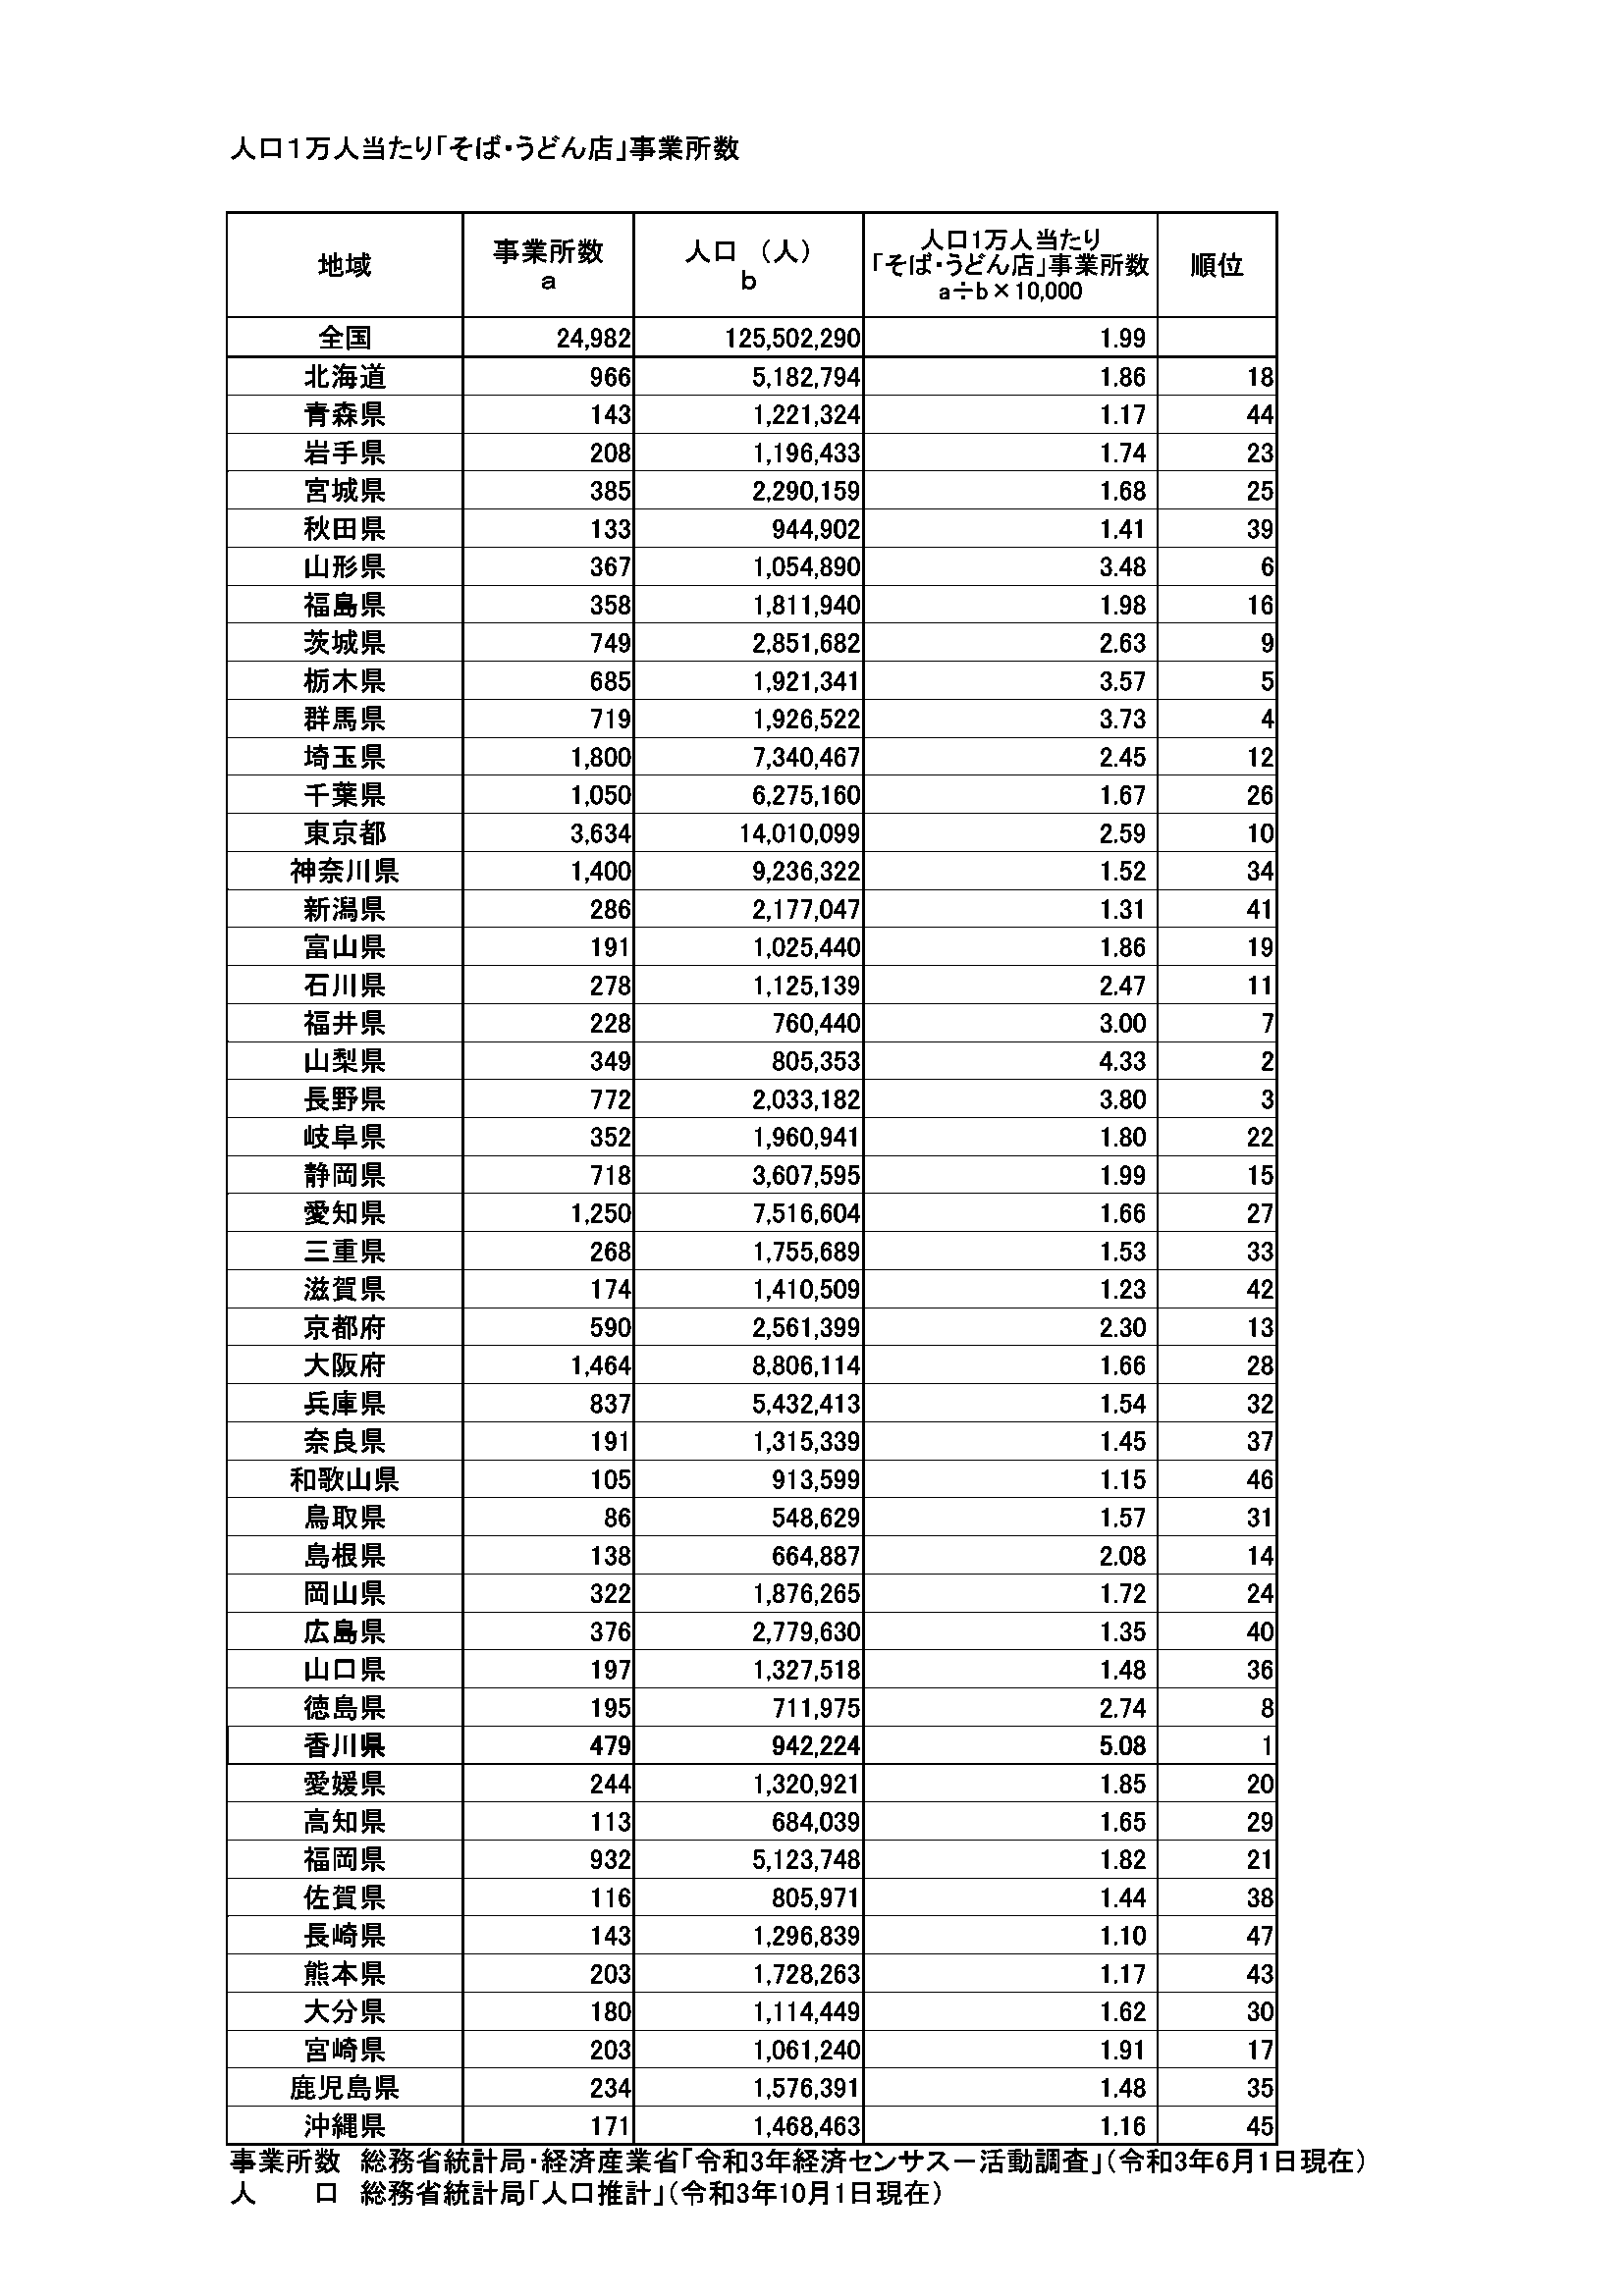

In [6]:
// threshold
const thresh = 220;
cv.threshold(
  workImage,
  workImage,
  thresh,
  255,
  cv.THRESH_BINARY
);
await print(workImage)

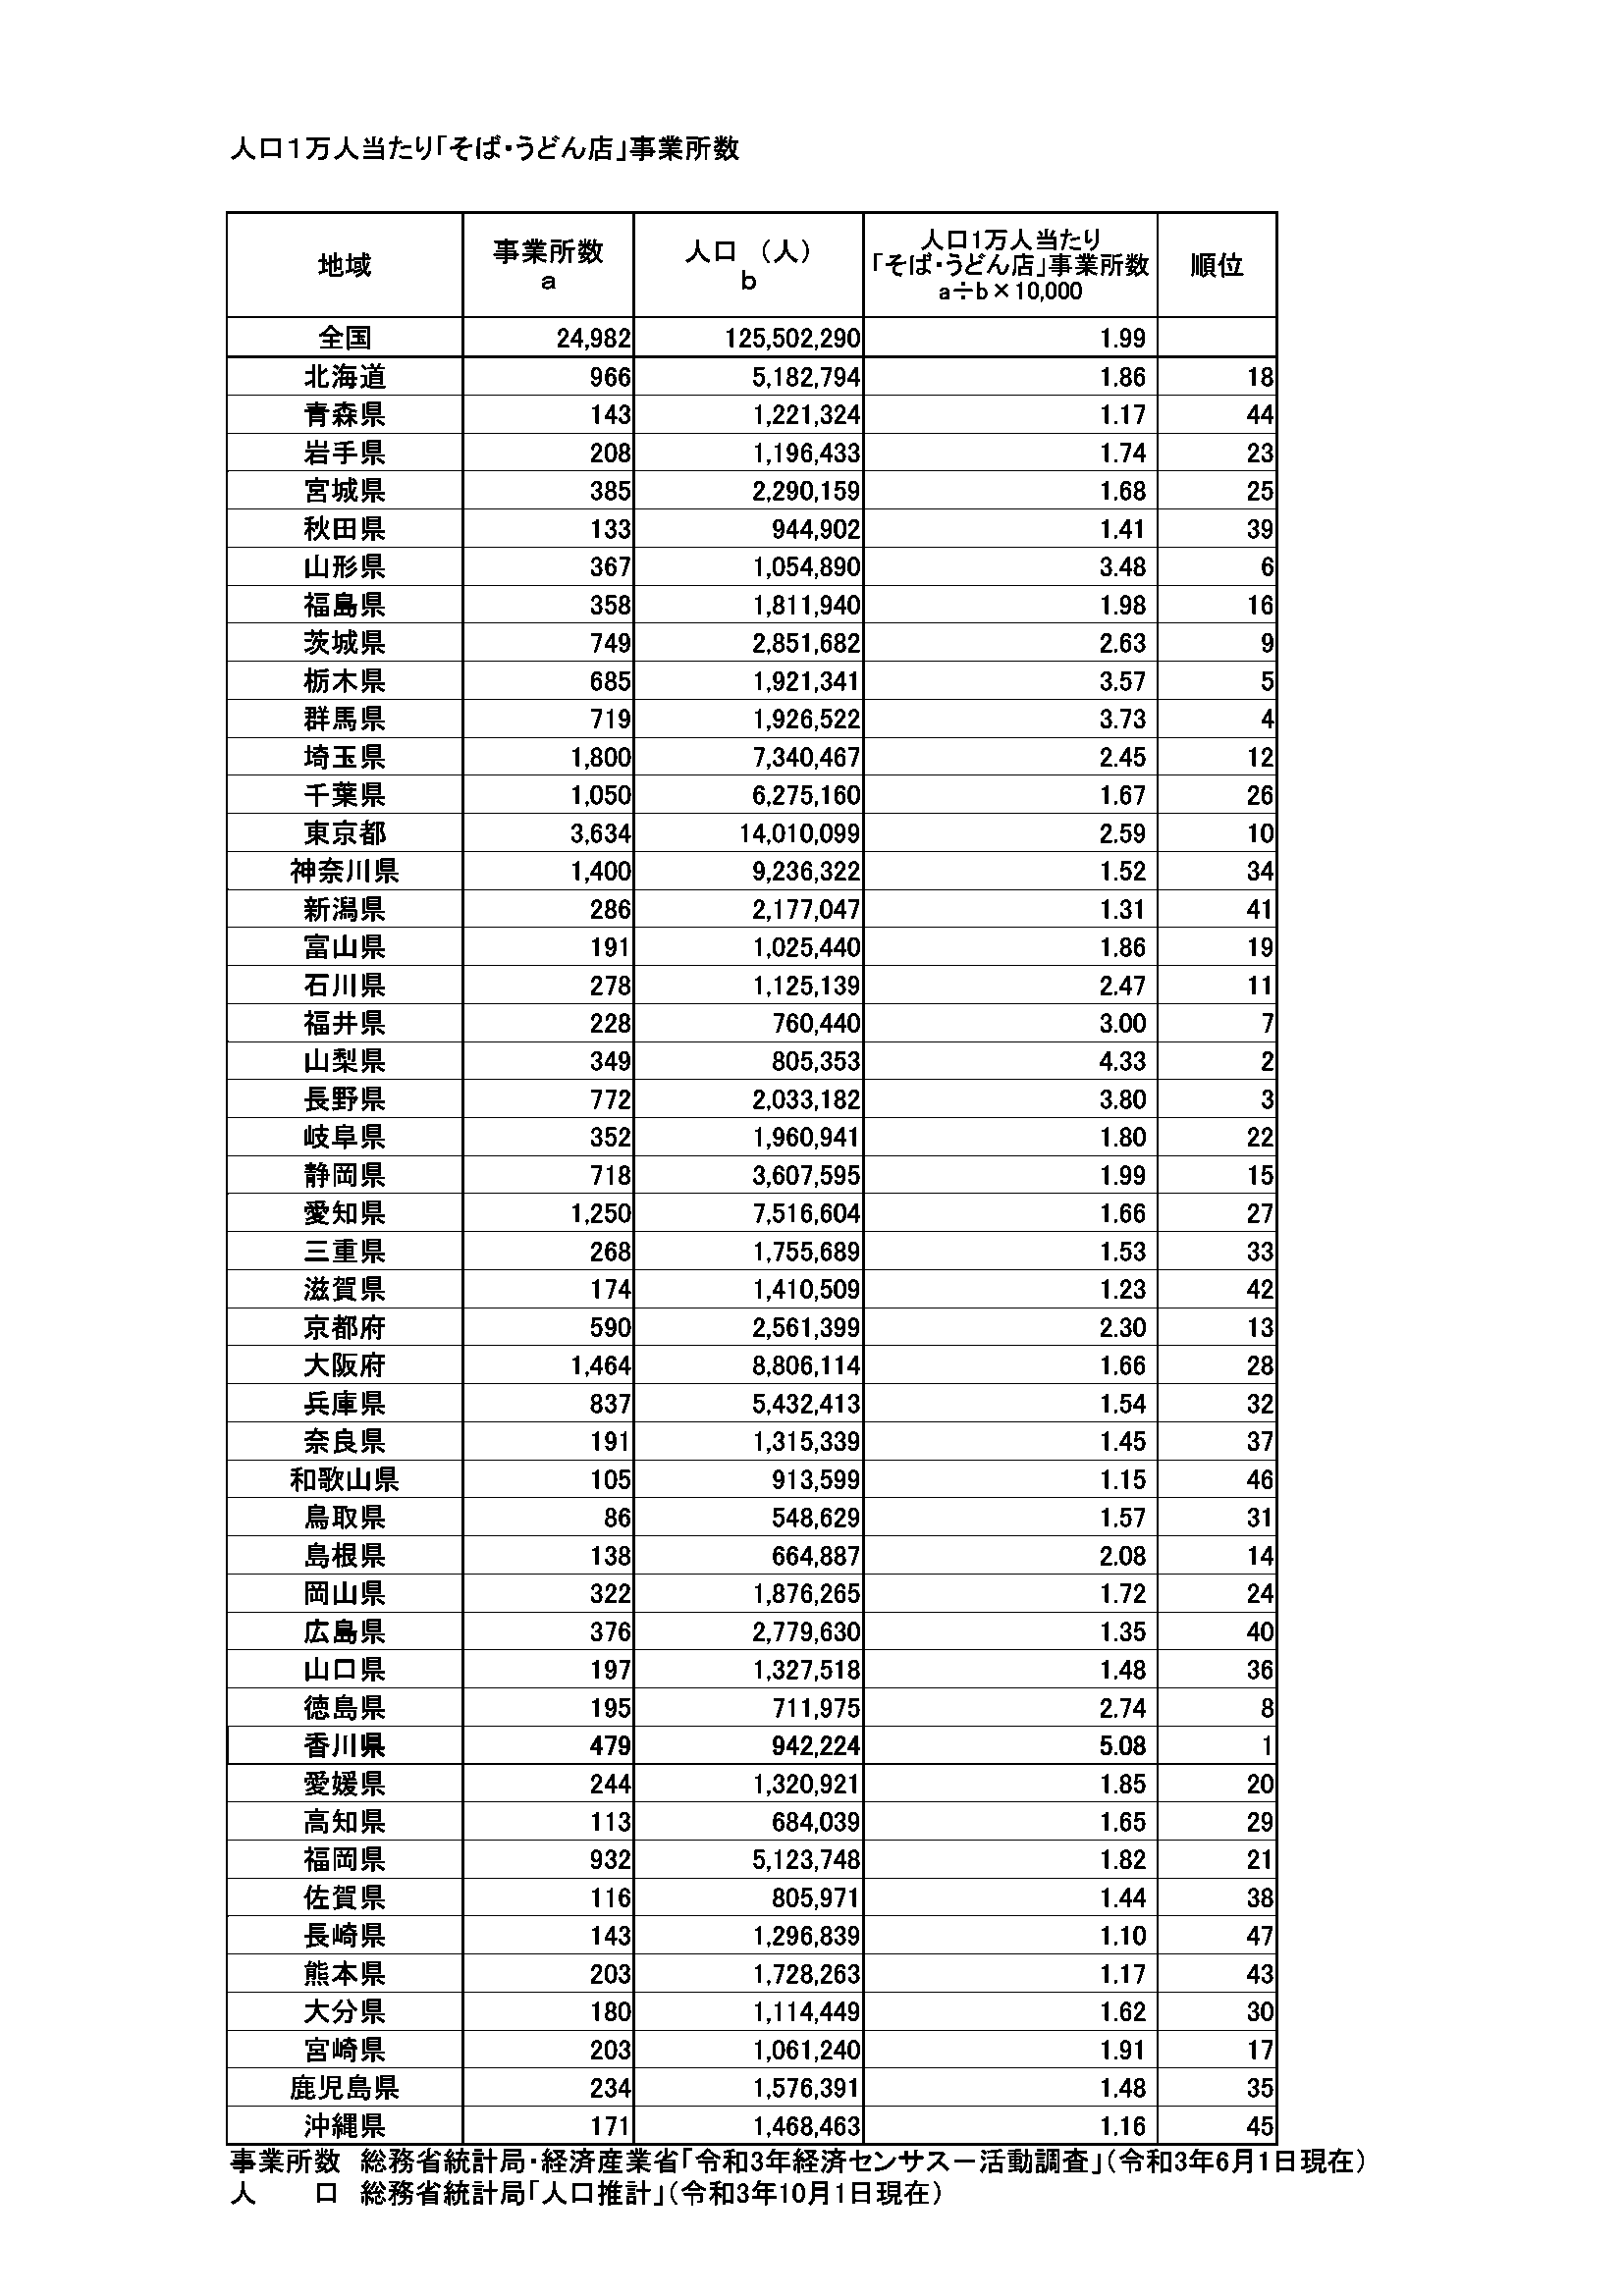

In [7]:
// adaptive threshold
const adaptiveThreshBlockSize = 11;
const adaptiveThreshWeight = 2;
cv.adaptiveThreshold(
  workImage,
  workImage,
  255,
  cv.ADAPTIVE_THRESH_GAUSSIAN_C,
  cv.THRESH_BINARY,
  adaptiveThreshBlockSize,
  adaptiveThreshWeight
);
await print(workImage)

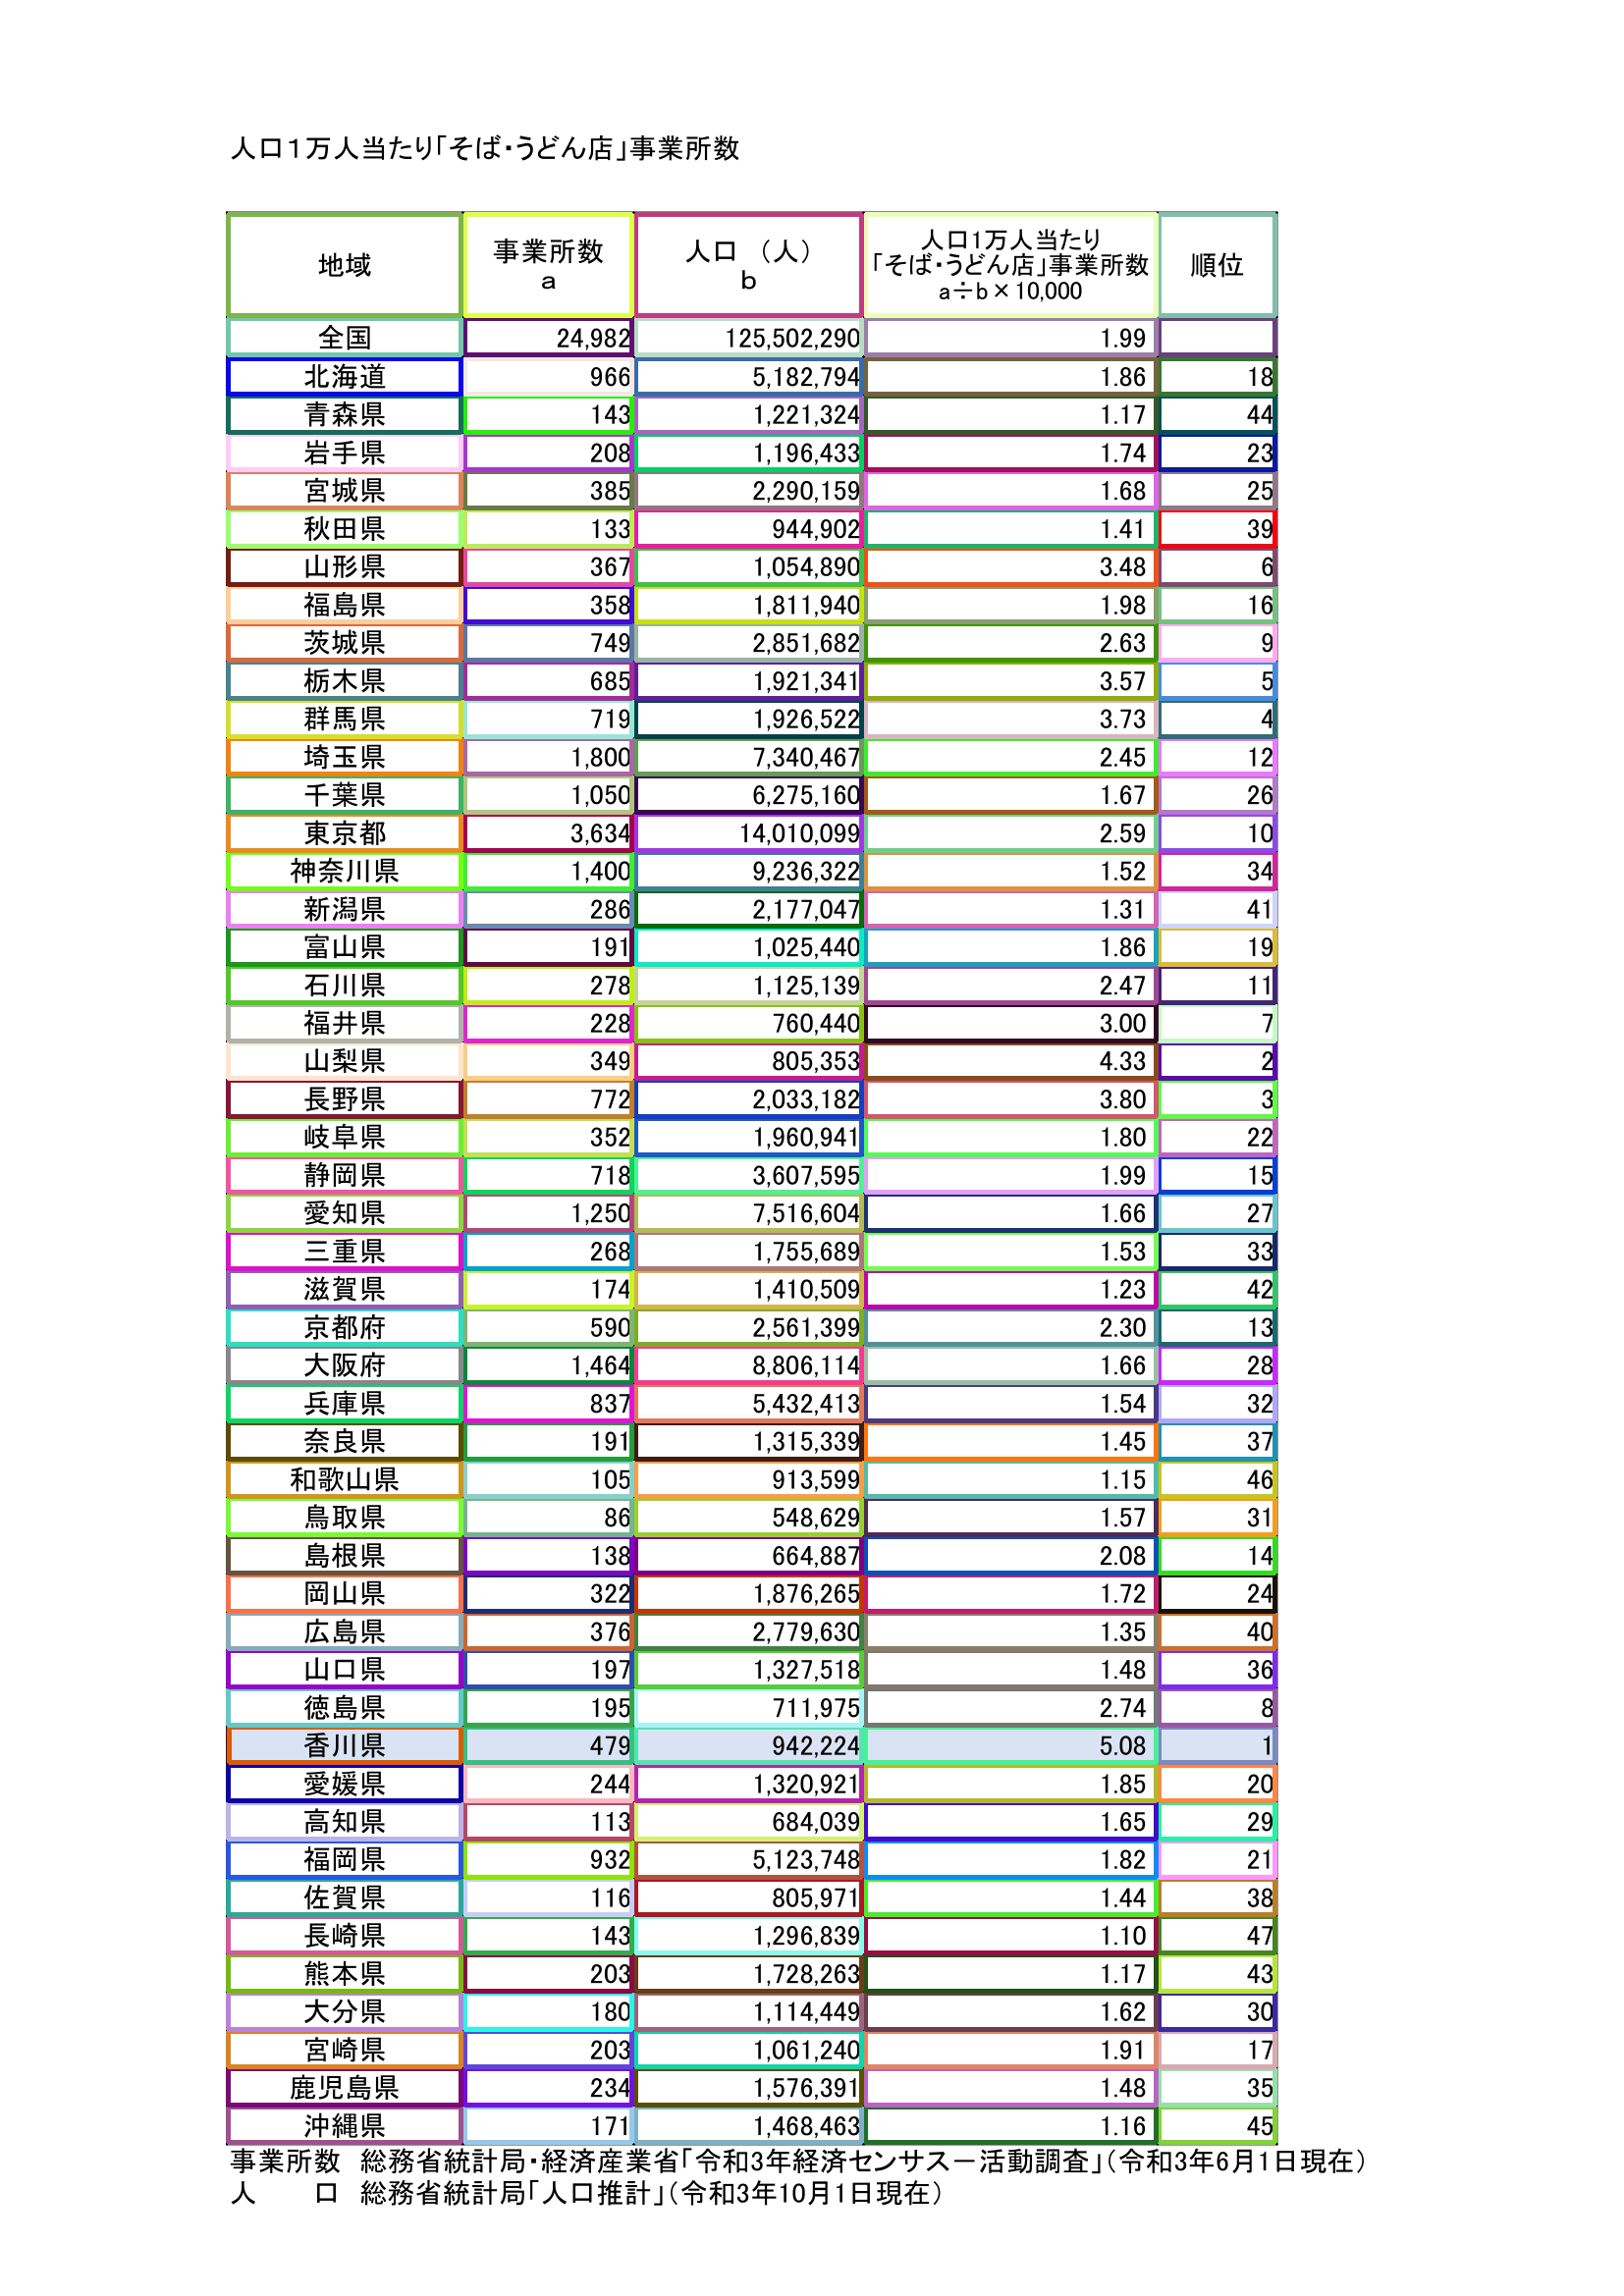

In [8]:
// Contour detection
const overrideImageMat = imageMat.clone()

const contours = new cv.MatVector();
const hierarchy = new cv.Mat();
cv.findContours(
  workImage,
  contours,
  hierarchy,
  cv.RETR_TREE,
  cv.CHAIN_APPROX_SIMPLE
);

const rects: cv.Rect[] = []
for (let i = 0; i < contours.size(); i++) {
  if (cv.contourArea(contours.get(i)) < 1000) {
    continue
  }
  if (cv.contourArea(contours.get(i)) > 35000) {
    continue
  }

  const rect = cv.boundingRect(contours.get(i));
  rects.push(rect)

  const color = new cv.Scalar(
    Math.random() * 255,
    Math.random() * 255,
    Math.random() * 255,
    255
  );
  cv.drawContours(overrideImageMat, contours, i, color, 3);
}

await print(overrideImageMat)

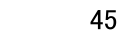

45



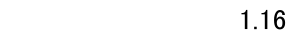

1.16



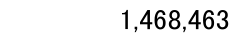

1.468,463



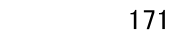

171



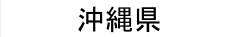

沖縄 県



In [9]:
const worker = await createWorker("jpn")
try {
  const ocrData: { text: string, image: cv.Mat }[] = []
  for (const rect of rects) {
    const cellImageMat = imageMat.roi(rect).clone()
    const cellImage = toImage(cellImageMat)
    const result = await worker.recognize(await cellImage.getBufferAsync(cellImage.getMIME()))
  
    ocrData.push({
      text: result.data.text,
      image: cellImageMat
    })
  }
  
  for (let i = 0; i < 5; i++) {
    const ocrDatum = ocrData[i]
    await print(ocrDatum.image)
    console.log(ocrDatum.text)
  }
} finally {
  worker.terminate()
}